In [1]:
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
sns.set_theme('paper', 'white', font='helvetica', font_scale=1.25, palette='tab10')

cm = 1/2.54  # centimeters in inches
bids_folder = '/data/ds-risk'

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def load(model_label, session, bids_folder='/data/ds-risk'):
    df = get_data(model_label, session, bids_folder)
    model = build_model(model_label, df, session, bids_folder)
    if session is None:
        idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_trace.netcdf')
    else:
        idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')

    return df, model, idata

def get_hdi(x):
    return tuple(az.hdi(x.values))

# Probit neural 3 (complex)

## 3T

In [14]:
df, model, idata = load('probit_neural3', '3t2')
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

100%|██████████| 30/30 [00:01<00:00, 25.30it/s]


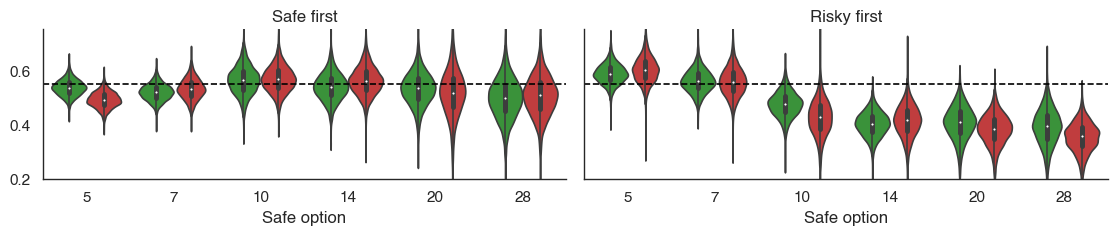

In [15]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='n_safe', y='rnp', hue='Neural uncertainty', col='Order', kind='violin', palette=sns.color_palette()[2:],
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                  col_order=['Safe first', 'Risky first'], aspect=2.25, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel='Safe option', ylim=(0.2, 0.75))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')

0.4799583333333333
0.386625


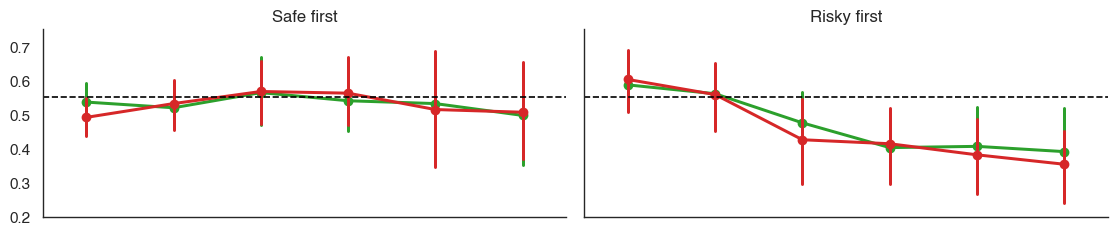

In [16]:
fac = sns.catplot(data=rnp.reset_index(), x='n_safe', y='rnp', hue='Neural uncertainty', col='Order', kind='point', palette=sns.color_palette()[2:],
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                  col_order=['Safe first', 'Risky first'], aspect=2.25, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


print(((rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())
print(((rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')

In [17]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp = rnp[(rnp > 0.0) & (rnp < 1.)]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


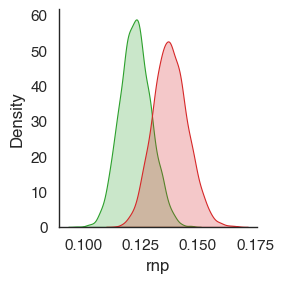

In [18]:
tmp = rnp.groupby(['subject', 'chain', 'draw', 'median_split_sd']).std().groupby(['chain', 'draw', 'median_split_sd']).mean()

fac = sns.FacetGrid(tmp.reset_index(), hue='median_split_sd',  palette=sns.color_palette()[2:])
fac.map(sns.kdeplot, 'rnp', fill=True)

0.012


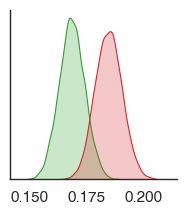

In [19]:
rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()

tmp = rnp.groupby(['chain', 'draw', 'median_split_sd']).mean()

fac = sns.FacetGrid(tmp.reset_index(), hue='median_split_sd', palette=sns.color_palette()[2:],
                    height=6.4*cm)
fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

fac.set(xlabel=None, ylabel=None, yticks=[])

split = tmp['distance_to_risk_neutral'].unstack('median_split_sd')
print((split[False] > split[True]).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp_distance.pdf'), bbox_inches='tight')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_39560/2488332424.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]


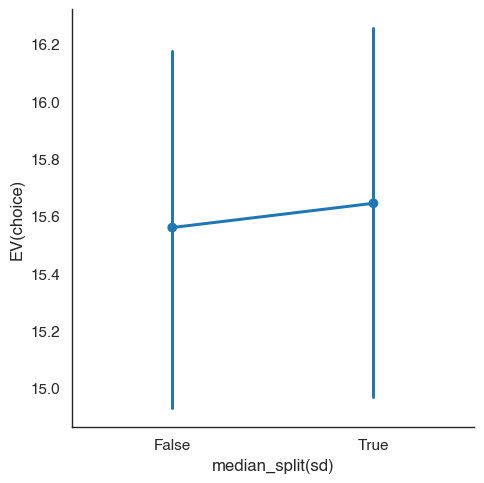

In [20]:
df['EV1'] = df['prob1']*df['n1']
df['EV2'] = df['prob2']*df['n2']

df.loc[df.choice == 1.0, 'EV(choice)'] = df['EV1']
df.loc[df.choice == 2.0, 'EV(choice)'] = df['EV2']
tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]
sns.catplot(tmp.reset_index(), x='median_split(sd)', y='EV(choice)', kind='point')

In [21]:
import pingouin
pingouin.rm_anova(tmp.reset_index(), dv='EV(choice)', within='median_split(sd)', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,median_split(sd),1,29,0.554088,0.462642,0.000572,1.0


In [22]:
from risk_experiment.utils import get_all_behavior, get_all_subjects
from itertools import product

df = get_all_behavior(bids_folder=bids_folder)
decoding_info = pd.concat([sub.get_decoding_info(session, mask='npcr', n_voxels=0.0) for sub, session in product(get_all_subjects(bids_folder), ['3t2', '7t2'])])
df = df.join(decoding_info)
df['median_split(sd)'] = df.groupby(['subject', 'session', 'n1', 'n2'], group_keys=False)['sd'].apply(lambda d: d>d.quantile())

100%|██████████| 30/30 [00:01<00:00, 18.39it/s]


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_39560/1647099901.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,median_split(sd),1,29,5.027526,0.032762,0.002437,1.0


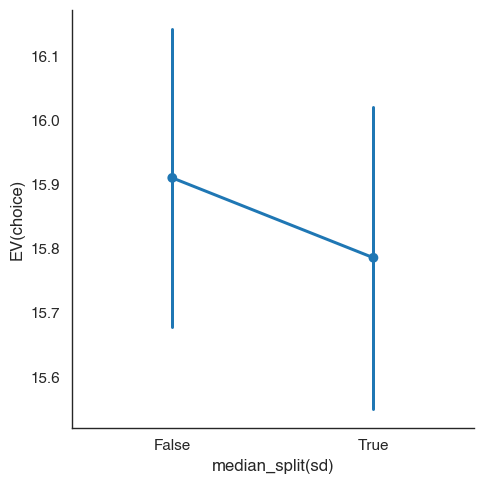

In [23]:
df['EV1'] = df['prob1']*df['n1']
df['EV2'] = df['prob2']*df['n2']

df.loc[df.choice == 1.0, 'EV(choice)'] = df['EV1']
df.loc[df.choice == 2.0, 'EV(choice)'] = df['EV2']
tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]
sns.catplot(tmp.reset_index(), x='median_split(sd)', y='EV(choice)', kind='point', errorbar='se')
import pingouin
pingouin.rm_anova(tmp.reset_index(), dv='EV(choice)', within='median_split(sd)', subject='subject')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_39560/3936560464.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject', 'median_split(sd)', 'risky_first']).mean()[['EV(choice)']]


             Source  ddof1  ddof2         F     p-unc       ng2  eps
0  median_split(sd)      1     29  1.544479  0.223907  0.001457  1.0
             Source  ddof1  ddof2         F     p-unc       ng2  eps
0  median_split(sd)      1     29  3.289317  0.080093  0.003435  1.0


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

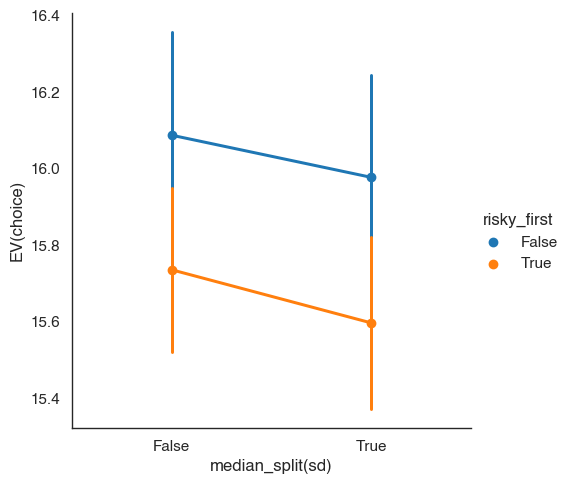

In [24]:
tmp = df.groupby(['subject', 'median_split(sd)', 'risky_first']).mean()[['EV(choice)']]
sns.catplot(tmp.reset_index(), x='median_split(sd)', y='EV(choice)', hue='risky_first', kind='point', errorbar='se')
import pingouin
print(pingouin.rm_anova(tmp.xs(False, 0, 'risky_first').reset_index(), dv='EV(choice)', within='median_split(sd)', subject='subject'))
print(pingouin.rm_anova(tmp.xs(True, 0, 'risky_first').reset_index(), dv='EV(choice)', within='median_split(sd)', subject='subject'))


## 7T

In [25]:
df, model, idata = load('probit_neural3', '7t2')

100%|██████████| 30/30 [00:01<00:00, 27.45it/s]


In [26]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

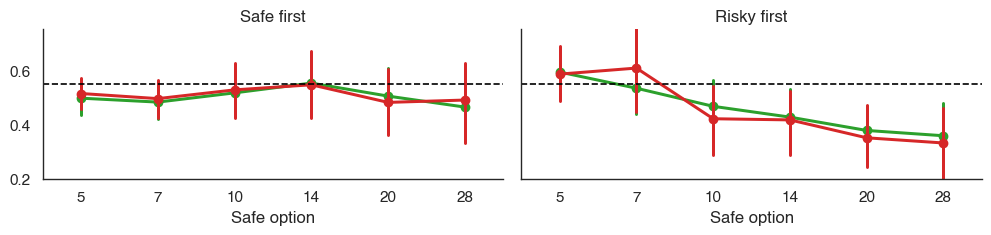

In [27]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='n_safe', y='rnp', hue='Neural uncertainty', col='Order', kind='point', palette=sns.color_palette()[2:],
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                #    errwidth=5,
                  col_order=['Safe first', 'Risky first'], aspect=2., height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel='Safe option', ylim=(0.2, 0.75))
fac.set_titles('{col_name}')
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')

In [28]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp = rnp[(rnp > 0.0) & (rnp < 1.)]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


0.013


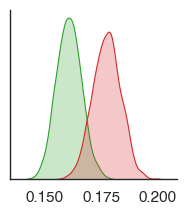

In [29]:
rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

tmp = rnp.groupby(['chain', 'draw', 'Neural uncertainty']).mean()

fac = sns.FacetGrid(tmp.reset_index(), hue='Neural uncertainty', palette=sns.color_palette()[2:],
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                    height=6.4*cm)
fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

fac.set(xlabel=None, ylabel=None, yticks=[])
split = tmp['distance_to_risk_neutral'].unstack('Neural uncertainty')
print((split['Low neural uncertainty'] > split['High neural uncertainty']).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_model-rnp_neural1_rnp_distance.pdf'), bbox_inches='tight')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_39560/2488332424.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]


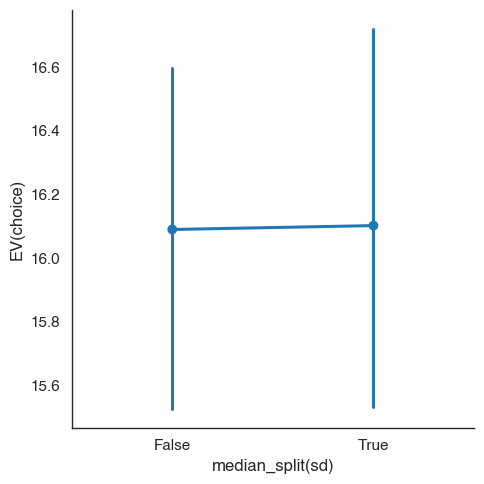

In [30]:
df['EV1'] = df['prob1']*df['n1']
df['EV2'] = df['prob2']*df['n2']

df.loc[df.choice == 1.0, 'EV(choice)'] = df['EV1']
df.loc[df.choice == 2.0, 'EV(choice)'] = df['EV2']
tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]
sns.catplot(tmp.reset_index(), x='median_split(sd)', y='EV(choice)', kind='point')

In [31]:
import pingouin
pingouin.rm_anova(tmp.reset_index(), dv='EV(choice)', within='median_split(sd)', subject='subject')
split = tmp.unstack('median_split(sd)')['EV(choice)']
pingouin.ttest(split[False], split[True], paired=True)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.112038,29,two-sided,0.911565,"[-0.23, 0.21]",0.007348,0.196,0.050174


## Both (probit neural 9)

In [32]:
df, model, idata = load('probit_neural9', None)

100%|██████████| 30/30 [00:01<00:00, 19.38it/s]


In [33]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

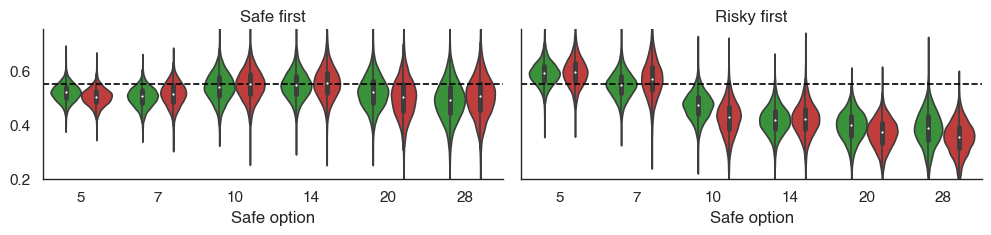

In [34]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='n_safe', y='rnp', hue='Neural uncertainty', col='Order', kind='violin', palette=sns.color_palette()[2:],
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                  col_order=['Safe first', 'Risky first'], aspect=2., height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel='Safe option', ylim=(0.2, 0.75))
fac.set_titles('{col_name}')
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-rnp_neural1_rnp.pdf'), bbox_inches='tight')

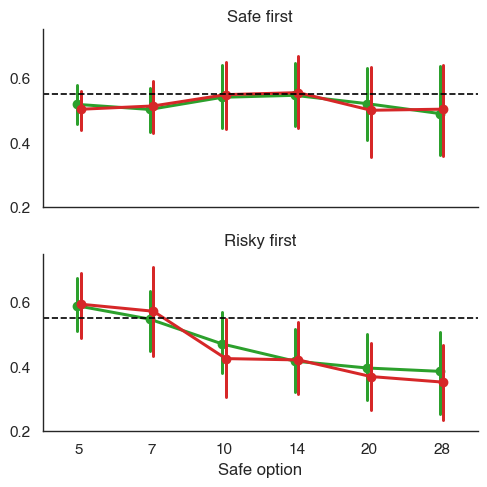

In [35]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='n_safe', y='rnp', hue='Neural uncertainty', row='Order', kind='point', palette=sns.color_palette()[2:],
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                #    errwidth=3,
                dodge=True,
                  col_order=['Safe first', 'Risky first'], aspect=2., height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel='Safe option', ylim=(0.2, 0.75))
fac.set_titles('{row_name}')
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'rnp_neural1_rnp.pdf'), bbox_inches='tight')

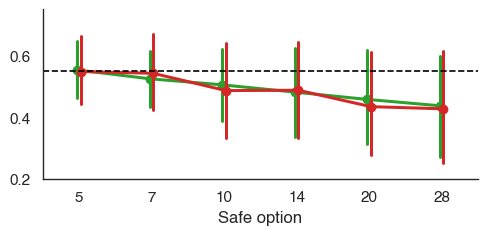

In [36]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='n_safe', y='rnp', hue='Neural uncertainty', kind='point', palette=sns.color_palette()[2:],
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                #    errwidth=3,
                dodge=True,
                  col_order=['Safe first', 'Risky first'], aspect=2., height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel='Safe option', ylim=(0.2, 0.75))
fac.set_titles('{col_name}')
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'rnp_neural1_rnp.pdf'), bbox_inches='tight')

In [37]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp = rnp[(rnp > 0.0) & (rnp < 1.)]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


0.0


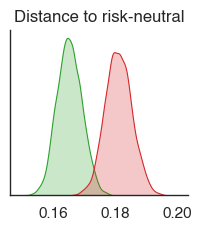

In [38]:
rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

tmp = rnp.groupby(['chain', 'draw', 'Neural uncertainty']).mean()

fac = sns.FacetGrid(tmp.reset_index(), hue='Neural uncertainty', palette=sns.color_palette()[2:],
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                    height=2.5, aspect=1.1)
fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)
plt.title('Distance to risk-neutral')

fac.set(xlabel=None, ylabel=None, yticks=[])
split = tmp['distance_to_risk_neutral'].unstack('Neural uncertainty')
print((split['Low neural uncertainty'] > split['High neural uncertainty']).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-rnp_neural9_rnp_distance.pdf'), bbox_inches='tight')

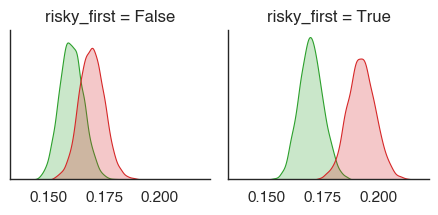

In [39]:
tmp = rnp.groupby(['chain', 'draw', 'Neural uncertainty', 'risky_first']).mean()

fac = sns.FacetGrid(tmp.reset_index(), hue='Neural uncertainty', palette=sns.color_palette()[2:],
                    col='risky_first',
                   hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                    height=6.4*cm)
fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

fac.set(xlabel=None, ylabel=None, yticks=[])

# Probit Neural 5 (neural x order)

## 3T

100%|██████████| 30/30 [00:01<00:00, 28.55it/s]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.336 0.06825 1.0


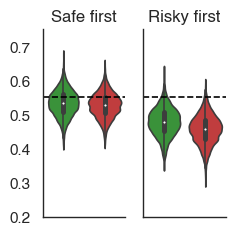

In [5]:
df, model, idata  = load('probit_neural5', '3t2')

intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', col='Order', kind='violin', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')


diff1 = ((rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean()
diff2 = ((rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean()

print(diff1, diff2, (diff1 > diff2).mean())


gamma = gamma.stack([-1, -2])
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Neural uncertainty'] = gamma.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

In [6]:
import arviz as az

In [7]:
def get_hdi(x):
    return tuple(az.hdi(x.values))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.336
0.06825


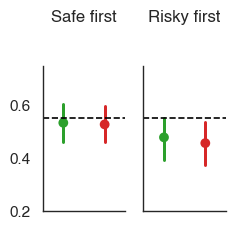

In [8]:
fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', col='Order', kind='point', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}', y=1.25)

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


print(((rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())
print(((rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_rnp.pdf'), bbox_inches='tight')

0.336
0.06825
0.09325


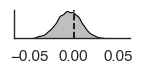

<Figure size 640x480 with 0 Axes>

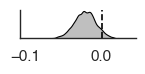

In [9]:
diff1 = (rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp'])
print((diff1 > 0.0).mean())
sns.kdeplot(diff1, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/ses_3t2_rnp_diff_safe_first.pdf', bbox_inches='tight')

sns.despine()
plt.figure()

plt.figure()
diff2 = (rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp'])
print((diff2 > 0.0).mean())
sns.kdeplot(diff2, fill=True, color='k')
plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, 0.375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

print(((diff1 + diff2) > 0.0).mean())

plt.savefig('/data/ds-risk/derivatives/figures/ses-3t2_rnp_diff_risky_first.pdf', bbox_inches='tight')

0.78775
0.386


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


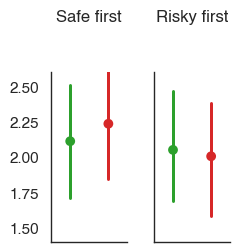

In [10]:
fac = sns.catplot(data=gamma.reset_index(), x='Neural uncertainty', y='gamma', col='Order', kind='point', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=[1.4, 2.6])
fac.set_titles('{col_name}', y=1.25)

# fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


print(((gamma.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma']) > 0.0).mean())
print(((gamma.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma']) > 0.0).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_neural_gamma.pdf'), bbox_inches='tight')

0.78775
0.386
0.634


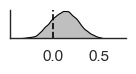

<Figure size 640x480 with 0 Axes>

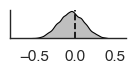

In [11]:
diff1 = (gamma.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma'])
print((diff1 > 0.0).mean())
sns.kdeplot(diff1, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/ses_3t2_gamma_diff_safe_first.pdf', bbox_inches='tight')

sns.despine()
plt.figure()

plt.figure()
diff2 = (gamma.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma'])
print((diff2 > 0.0).mean())
sns.kdeplot(diff2, fill=True, color='k')
plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, 0.375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

print(((diff1 + diff2) > 0.0).mean())

plt.savefig('/data/ds-risk/derivatives/figures/ses-3t2_gamma_diff_risky_first.pdf', bbox_inches='tight')

## 7T

no outliers!


100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


0.80325
0.18625


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


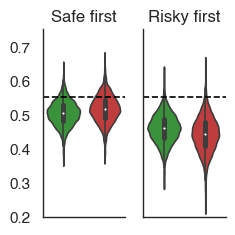

In [12]:
df, model, idata  = load('probit_neural5_no_outliers', '7t2')

intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', col='Order', kind='violin', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')


print(((rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())
print(((rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())

gamma = gamma.stack([-1, -2])
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Neural uncertainty'] = gamma.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

0.80325
0.18625


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


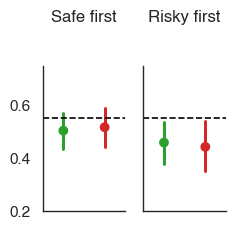

In [13]:
fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', col='Order', kind='point', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}', y=1.25)

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


print(((rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())
print(((rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_rnp.pdf'), bbox_inches='tight')


0.80325
0.18625
0.442


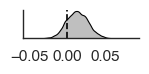

<Figure size 640x480 with 0 Axes>

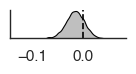

In [14]:
diff1 = (rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp'])
print((diff1 > 0.0).mean())
sns.kdeplot(diff1, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/ses_7t2_rnp_diff_safe_first.pdf', bbox_inches='tight')

sns.despine()
plt.figure()

plt.figure()
diff2 = (rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp'])
print((diff2 > 0.0).mean())
sns.kdeplot(diff2, fill=True, color='k')
plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, 0.375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

print(((diff1 + diff2) > 0.0).mean())

plt.savefig('/data/ds-risk/derivatives/figures/ses-7t2_rnp_diff_risky_first.pdf', bbox_inches='tight')

0.193
0.03475


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


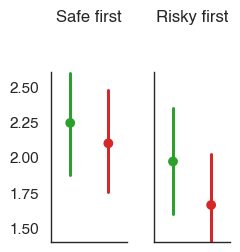

In [15]:
fac = sns.catplot(data=gamma.reset_index(), x='Neural uncertainty', y='gamma', col='Order', kind='point', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=[1.4, 2.6])
fac.set_titles('{col_name}', y=1.25)

# fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


print(((gamma.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma']) > 0.0).mean())
print(((gamma.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma']) > 0.0).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_neural_gamma.pdf'), bbox_inches='tight')

0.193
0.03475
0.035


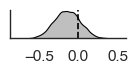

<Figure size 640x480 with 0 Axes>

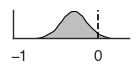

In [16]:
diff1 = (gamma.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma'])
print((diff1 > 0.0).mean())
sns.kdeplot(diff1, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/ses_3t2_gamma_diff_safe_first.pdf', bbox_inches='tight')

sns.despine()
plt.figure()

plt.figure()
diff2 = (gamma.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma'])
print((diff2 > 0.0).mean())
sns.kdeplot(diff2, fill=True, color='k')
plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, 0.375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

print(((diff1 + diff2) > 0.0).mean())

plt.savefig('/data/ds-risk/derivatives/figures/ses-3t2_gamma_diff_risky_first.pdf', bbox_inches='tight')

## Both

100%|██████████| 30/30 [00:01<00:00, 19.85it/s]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.5985
0.043


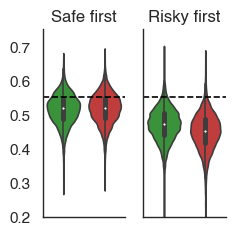

In [7]:
df, model, idata  = load('probit_neural8', None) # model 8 includes session effect

intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)

rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', col='Order', kind='violin', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')


print(((rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())
print(((rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean())

plt.savefig('/data/ds-risk/derivatives/figures/neural_rnp.pdf', bbox_inches='tight')


gamma = gamma.stack([-1, -2])
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Neural uncertainty'] = gamma.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

0.5985 0.043 1.0


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


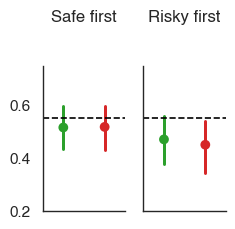

In [8]:
fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', col='Order', kind='point', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}', y=1.25)

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


diff1 = ((rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean()
diff2 = ((rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp']) > 0.0).mean()
print(diff1 , diff2, (diff1 - diff2 > 0.0).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'neural_rnp.pdf'), bbox_inches='tight')

0.5985
0.043
0.94675


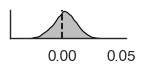

<Figure size 640x480 with 0 Axes>

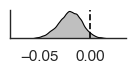

In [9]:
diff1 = (rnp.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp'])
print((diff1 > 0.0).mean())
sns.kdeplot(diff1, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/7t2_rnp_diff_safe_first.pdf', bbox_inches='tight')

sns.despine()
plt.figure()

plt.figure()
diff2 = (rnp.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['rnp'])
print((diff2 > 0.0).mean())
sns.kdeplot(diff2, fill=True, color='k')
plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, 0.375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

print(((diff1 - diff2) > 0.0).mean())

plt.savefig('/data/ds-risk/derivatives/figures/rnp_diff_risky_first.pdf', bbox_inches='tight')

0.4355
0.043


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


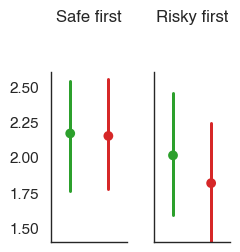

In [55]:
fac = sns.catplot(data=gamma.reset_index(), x='Neural uncertainty', y='gamma', col='Order', kind='point', palette=sns.color_palette()[2:],
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                   errorbar=get_hdi,
                  col_order=['Safe first', 'Risky first'], aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=[1.4, 2.6])
fac.set_titles('{col_name}', y=1.25)

# fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


print(((gamma.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma']) > 0.0).mean())
print(((gamma.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(True, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma']) > 0.0).mean())
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'neural_gamma.pdf'), bbox_inches='tight')

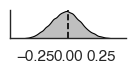

<Figure size 640x480 with 0 Axes>

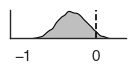

In [56]:
sns.kdeplot((gamma.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(False, 0, 'risky_first').xs(False, 0, 'median_split_sd')['gamma']), fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/gamma_diff_safe_first.pdf', bbox_inches='tight')

sns.despine()
plt.figure()

plt.figure()
sns.kdeplot((gamma.xs(True, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma'] - gamma.xs(False, 0, 'risky_first').xs(True, 0, 'median_split_sd')['gamma']), fill=True, color='k')
plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, 0.375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/gamma_diff_risky_first.pdf', bbox_inches='tight')

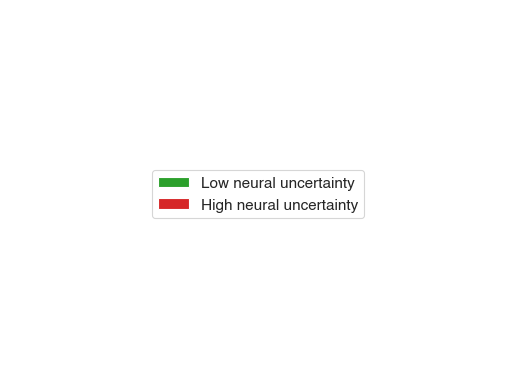

In [57]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


fig = plt.gcf()

legend_elements = [Patch(facecolor=sns.color_palette()[2], label='Low neural uncertainty'),
                   Patch(facecolor=sns.color_palette()[3], label='High neural uncertainty') ]


legend = plt.legend(handles=legend_elements, loc='center')
plt.axis('off')

bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.savefig('/data/ds-risk/derivatives/figures/neural_legend.pdf', bbox_inches=bbox)

# Simplest model (x*median_split)

## 3T

100%|██████████| 30/30 [00:01<00:00, 29.88it/s]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


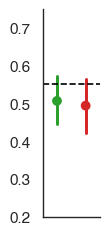

In [58]:
df, model, idata  = load('probit_neural4', '3t2')

intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', kind='point', palette=sns.color_palette()[2:],
                    errorbar=get_hdi,
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                  aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')


0.11775

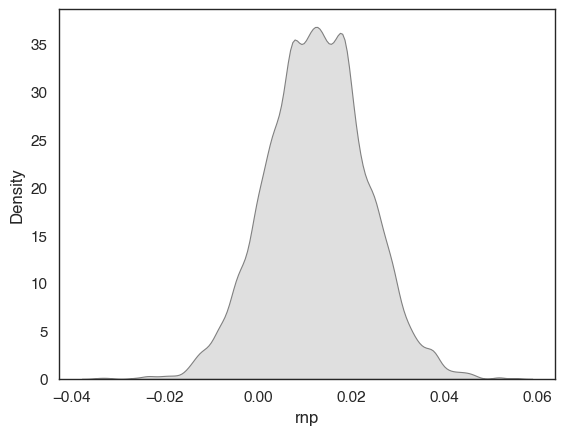

In [59]:
diff = rnp.xs(False, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'median_split_sd')['rnp']
sns.kdeplot(diff, fill=True, color='gray')
(diff < 0.0).mean()

0.04575

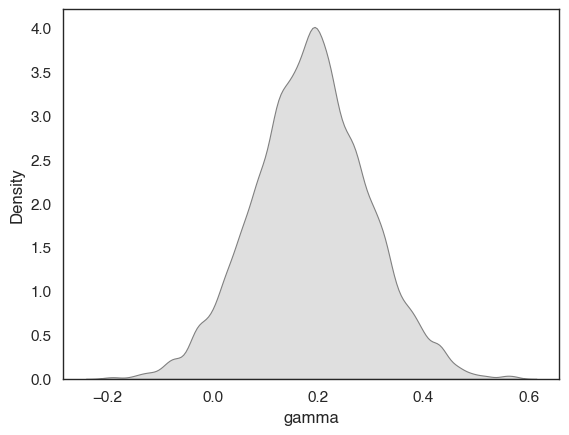

In [60]:
gamma = gamma.stack([-1, -2])
diff = gamma.xs(False, 0, 'median_split_sd')['gamma'] - gamma.xs(True, 0, 'median_split_sd')['gamma']
sns.kdeplot(diff, fill=True, color='gray')
(diff < 0.0).mean()

## 7T

100%|██████████| 30/30 [00:01<00:00, 28.34it/s]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


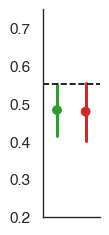

In [61]:
df, model, idata  = load('probit_neural4', '7t2')

intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', kind='point', palette=sns.color_palette()[2:],
                    errorbar=get_hdi,
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                  aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')


0.36225

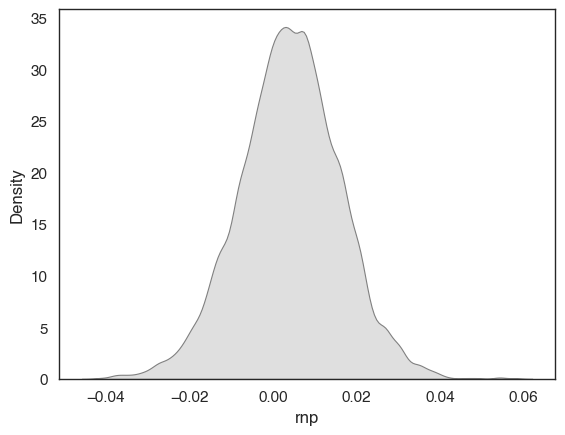

In [62]:
diff = rnp.xs(False, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'median_split_sd')['rnp']
sns.kdeplot(diff, fill=True, color='gray')
(diff < 0.0).mean()

0.02375

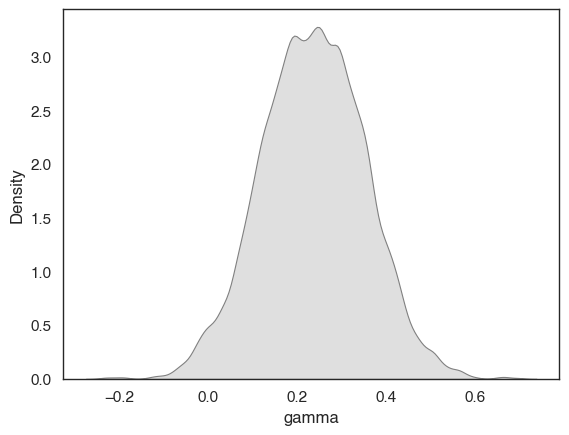

In [63]:
gamma = gamma.stack([-1, -2])
diff = gamma.xs(False, 0, 'median_split_sd')['gamma'] - gamma.xs(True, 0, 'median_split_sd')['gamma']
sns.kdeplot(diff, fill=True, color='gray')
(diff < 0.0).mean()

## Both

In [3]:
df, model, idata  = load('probit_neural10', None)

100%|██████████| 30/30 [00:01<00:00, 20.23it/s]


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


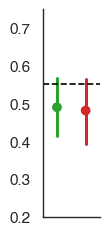

In [4]:

intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Neural uncertainty'] = rnp.index.get_level_values('median_split_sd').map({True:'High neural uncertainty', False:'Low neural uncertainty'})

fac = sns.catplot(data=rnp.reset_index(), x='Neural uncertainty', y='rnp', kind='point', palette=sns.color_palette()[2:],
                    errorbar=get_hdi,
                   order=['Low neural uncertainty', 'High neural uncertainty'],
                  aspect=.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.2, 0.75))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_model-rnp_neural1_rnp.pdf'), bbox_inches='tight')


0.151125

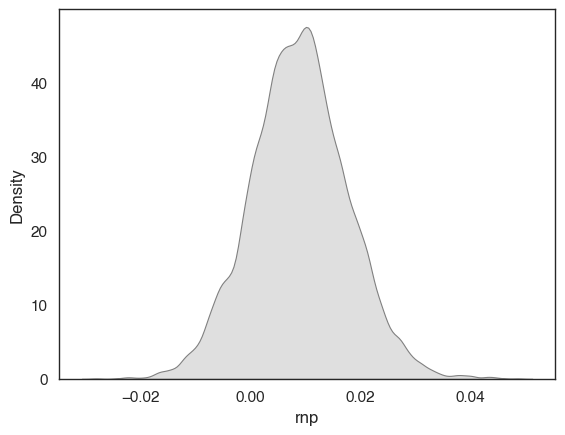

In [5]:
diff = rnp.xs(False, 0, 'median_split_sd')['rnp'] - rnp.xs(True, 0, 'median_split_sd')['rnp']
sns.kdeplot(diff, fill=True, color='gray')
(diff < 0.0).mean()

0.00325

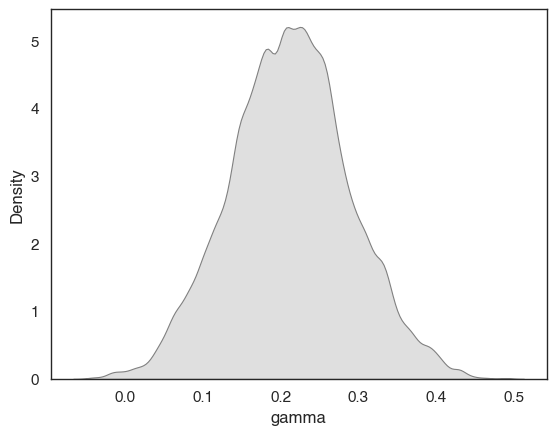

In [6]:
gamma = gamma.stack([-1, -2])
diff = gamma.xs(False, 0, 'median_split_sd')['gamma'] - gamma.xs(True, 0, 'median_split_sd')['gamma']
sns.kdeplot(diff, fill=True, color='gray')
(diff < 0.0).mean()
